In [1]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D
import nbimporter
import dynamicalModels as dynamicalModels
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm

Importing Jupyter notebook from dynamicalModels.ipynb


# Embedding 

In [2]:
def make_manifold_point(X,E,tau,t):
    '''
    Creates point on a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        t: a time point between (E-1)*tau < t < L
    Returns:
        X[range_revered_iterable]: a point in R^E.
    '''
    
    L = X.shape[0]
    range_iterable = range(t-(E-1)*tau,t+tau,tau)
    range_revered_iterable = list(reversed(range_iterable))
    return X[range_revered_iterable]

def make_manifold(X,E,tau):
    '''
    Creates a manifold embedded in R^E by time
    delaying the time series X by tau
    
    Args:
        X: Time series
        E: Dimension of embedding space
        tau: time delay
        
    Returns:
        embedding_x: a array of L - (E-1)*tau points
                    in R^E.
    '''
    
    # get length of time series
    L = X.shape[0]
    
    # initialize the embedding array matrix
    embedding_x =np.zeros((L - (E-1)*tau,E))
    
    i=0
    # create embedding matrix
    for t in range((E-1)*tau,L):
        # create a sequence of numbers between t-(E-1)*tau
        # and t+tau spaced by tau
    
        range_iterable = range(t-(E-1)*tau,t+tau,tau)
        
        #reverse the order of the sequence and coerce in a list
        range_revered_iterable = list(reversed(range_iterable))
        
        
        #put the entries of X at indices, range_revered_iterable,
        #in the ith row of embedding_x
        
        embedding_x[i,:] = X[range_revered_iterable]
        i+=1
    return embedding_x

def weight_function(distance):
    '''
    Exponentially weighted distance function
    
    Args:
        distance: a vector of distances
    Returns:
        u_i: normalized exponential weights
    '''
    
    non_indices=np.nonzero(distance)[0]
    if len(non_indices) == 0:
        norm_distance = 1
    else:
        norm_distance = distance[non_indices[0]]
    weighted_distance = np.exp(-distance/norm_distance)
    u_i = weighted_distance/np.sum(weighted_distance)
    return u_i


def generate_convergent_cross_approx(X,Y,E,tau):
    '''
    Approximates Y from X by 1) creating an embedding
    manifold of X, 2) mapping the neighbours of each point
    in the embedding manifold of X to the embedding manifold of 
    Y, 3) taking a exponetially weighted average of entries of 
    time series of Y associated the mapped neighbours.
    
    Args:
        X: time series used to estimate Y
        Y: time series to be estimated
        E: embedding dimension
        tau: time shift
        
    Returns:
        Y_approx: a L - (E-1)*tau time series appromixating
                  the last L - (E-1)*tau entries of Y.
    '''
    
    #makes X manifold

    xhat=make_manifold(X,E,tau)
    #number of time points to be approximated
    num_time_points = xhat.shape[0]
    
    #Initialized KNN object with xhat 
    nbrs = NearestNeighbors(n_neighbors=E+1, algorithm='ball_tree').fit(xhat)    
    
    # Computes the distance and indices of the E+1
    # nearest points of each point in xhat
    distances, indices = nbrs.kneighbors()
    
    # initial Y_approx
    Y_approx = np.zeros(num_time_points)
    
    #TODO: What about first (E-1)*tau points? I can still approximate the
    #using the last column of xhat
    for i in range(0,num_time_points):
        #computes the weight function
        u_i = weight_function(distances[i])
        #computes y approx
        Y_approx[i]= np.dot(Y[indices[i] + (E-1)*tau],u_i)
    return Y_approx

In [3]:
x0 = np.array([5.0, 5.0])
dt = 0.1
tinit = 0
tmax = 100
vdp = dynamicalModels.van_der_pol(2)
sol = vdp.integrate(tinit,tmax,dt,x0)
E=2
tau=1

## Causality from position to velocity

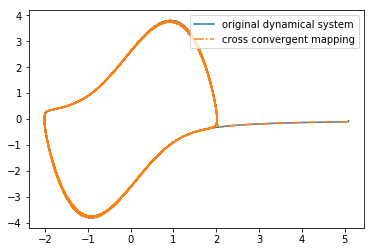

In [4]:
CCM_y1 = generate_convergent_cross_approx(sol.y[0,:],sol.y[1,:],E,tau)
plt.plot(sol.y[0,(E-1)*tau:],sol.y[1,(E-1)*tau:],'-')
plt.plot(sol.y[0,(E-1)*tau:],CCM_y1,'-.')
plt.legend(['original dynamical system','cross convergent mapping'],loc="upper right")
plt.show()

## Causality from position to velocity in Van der pol 

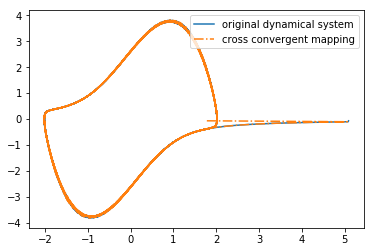

In [5]:
CCM_y0 = generate_convergent_cross_approx(sol.y[1,:],sol.y[0,:],E,tau)
plt.plot(sol.y[0,(E-1)*tau:],sol.y[1,(E-1)*tau:],'-')
plt.plot(CCM_y0,sol.y[1,(E-1)*tau:],'-.')
plt.legend(['original dynamical system','cross convergent mapping'],loc="upper right")
plt.show()